## IGO17721 3D KP Hopx-MACD BG 
9/23/25 - Data generated from IV transplanted cells - DT treated for 1 week; data submitted by CHP/EB on 9/2/2025; analyzed by JC 9/25/2025

Analyze global run on cellranger v8 data and create h5_ad files for further analysis - w/o introns

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import math
import matplotlib
from matplotlib import pyplot as plt

from pathlib import Path
import anndata

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
np.random.seed(1573)   #fix so we can reproduce later

In [3]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['figure.figsize'] = (3,4)

In [4]:
#Path("./figures/umapfigures").mkdir(parents=True, exist_ok=True) # generate figures here
Path("./write").mkdir(parents=True, exist_ok=True) # write h5ad here

In [5]:
results_file = 'write/GSE277777_IGO17721-KPHopxMACD-IV-DT.h5ad'  # the file that will store the analysis results

In [6]:
adata = sc.read_10x_h5('GSE277777_IGO17721-DT-filtered_feature_bc_matrix.h5', gex_only=False)

reading GSE277777_IGO17721-DT-filtered_feature_bc_matrix.h5
 (0:00:02)


/Users/chanj2/opt/miniconda3/envs/part1-cellrank/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

## Preprocessing

normalizing counts per cell
    finished (0:00:00)


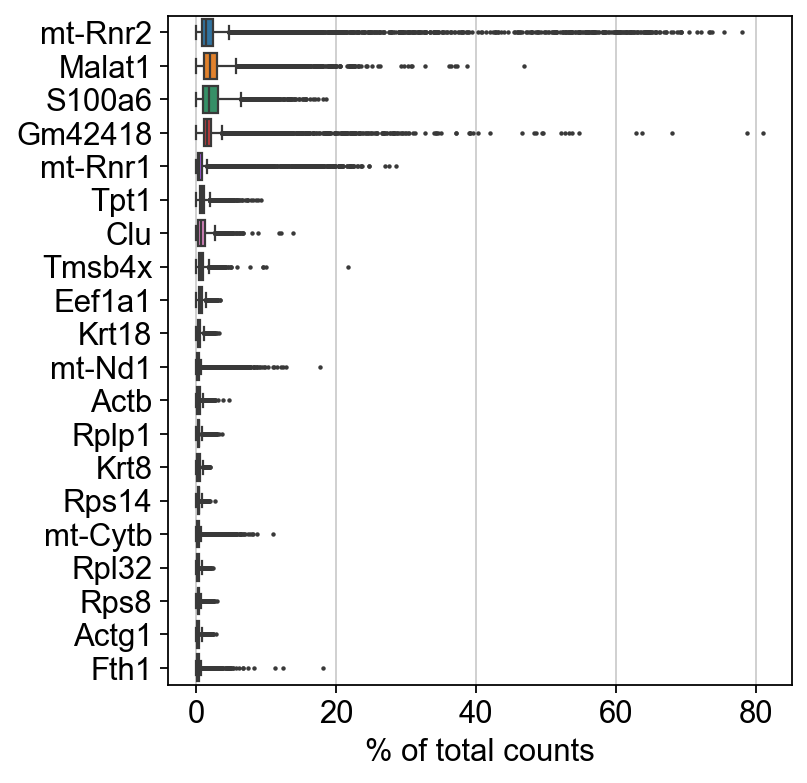

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [9]:
sc.pp.filter_cells(adata, min_counts=1500)
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 569 cells that have less than 1500 counts
filtered out 39 cells that have less than 300 genes expressed
filtered out 30822 genes that are detected in less than 3 cells


In [10]:
adata.var['mt'] = adata.var_names.str.startswith('mt-') # annotate the group of mitochondrial genes as 'MT'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

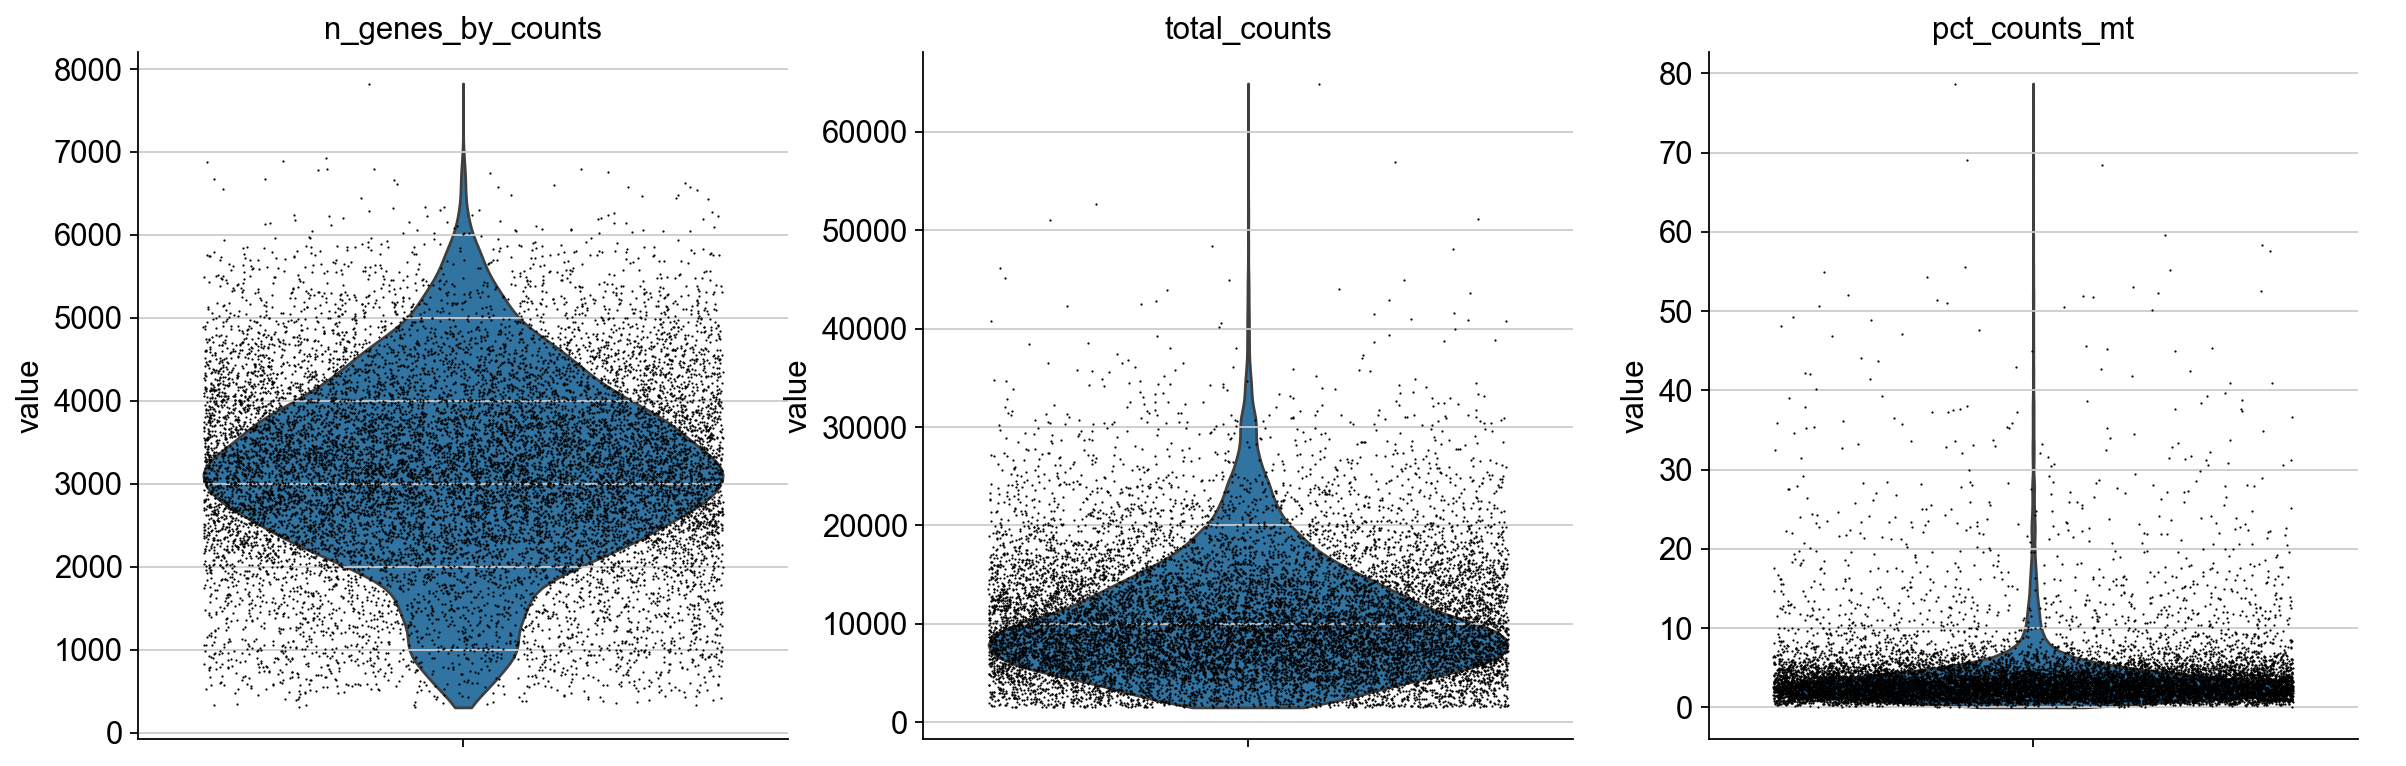

In [11]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, rotation=90)

(array([   7.,   27.,   56.,   88.,  192., 1329., 5209., 5775., 1671.,
          85.]),
 array([0.71153037, 0.73531072, 0.75909108, 0.78287143, 0.80665178,
        0.83043213, 0.85421249, 0.87799284, 0.90177319, 0.92555355,
        0.9493339 ]),
 <BarContainer object of 10 artists>)

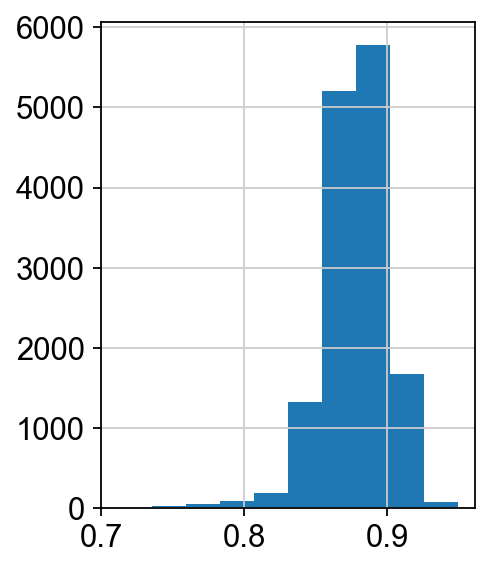

In [12]:
adata.obs["log10GenesPerUMI"] = adata.obs['n_genes_by_counts'].apply(math.log10) / adata.obs['total_counts'].apply(math.log10)
matplotlib.pyplot.hist(adata.obs["log10GenesPerUMI"])

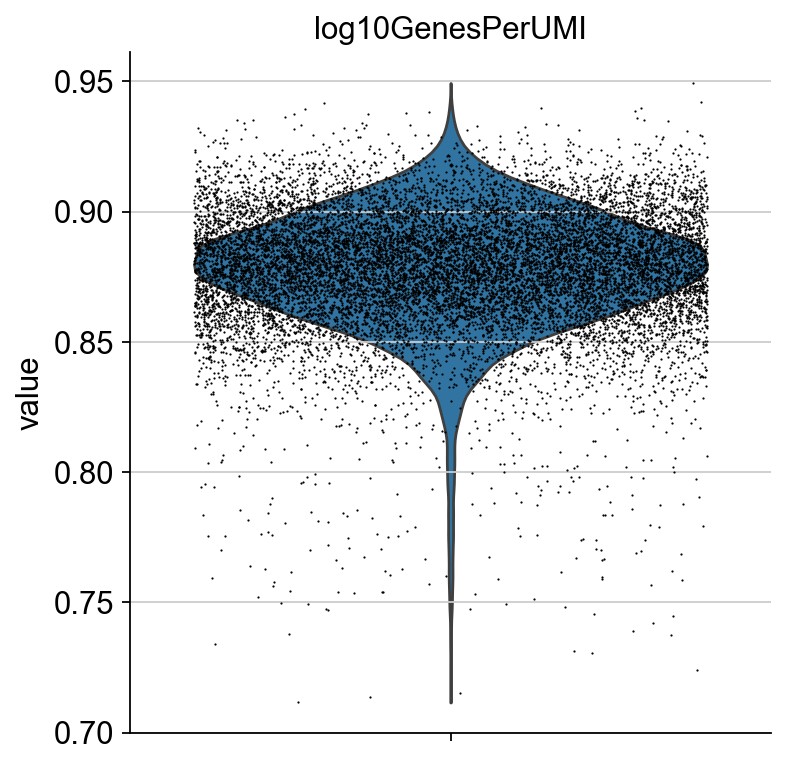

In [13]:
sc.pl.violin(adata, ['log10GenesPerUMI'],
             jitter=0.4, multi_panel=True, rotation=90)

In [14]:
#Filter by Log10GenesPerUMI
adata = adata[adata.obs.log10GenesPerUMI >= 0.8,:]

In [15]:
adata = adata[adata.obs.pct_counts_mt <= 20, :]

## add counts to transgenes

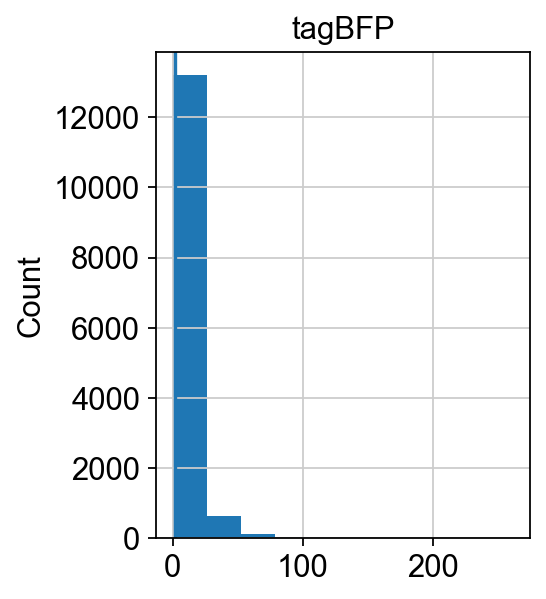

In [16]:
import matplotlib.pyplot as plt
_ = plt.hist(adata.X[:,adata.var.index.isin(['tagBFP'])].toarray())
plt.ylabel("Count")
plt.title("tagBFP")
plt.axvline(x=2)
plt.show()

In [17]:
adata.obs['tagBFP_count'] = adata.X[:,adata.var.index.isin(['tagBFP'])].toarray()

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_46494/2499316847.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['tagBFP_count'] = adata.X[:,adata.var.index.isin(['tagBFP'])].toarray()


In [18]:
adata.var.index

Index(['Xkr4', 'Gm37180', 'Gm37363', 'Gm37329', 'Gm19938', 'Rp1', 'Sox17',
       'Gm6085', 'Gm6119', 'Mrpl15',
       ...
       'Vamp7', 'Spry3', 'Tmlhe', 'Csprs', 'AC132444.6', 'AC149090.1',
       'CAAA01118383.1', 'CAAA01147332.1', 'EGFP', 'tagBFP'],
      dtype='object', length=24028)

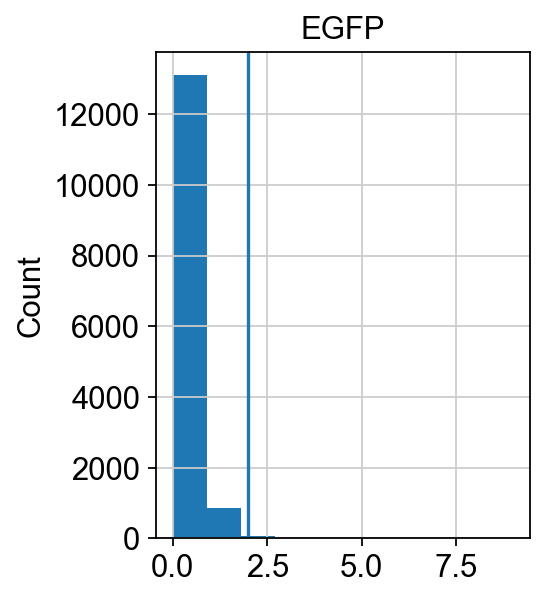

In [19]:
import matplotlib.pyplot as plt
_ = plt.hist(adata.X[:,adata.var.index.isin(['EGFP'])].toarray())
plt.ylabel("Count")
plt.title("EGFP")
plt.axvline(x=2)
plt.show()

In [20]:
adata.obs['EGFP_count'] = adata.X[:,adata.var.index.isin(['EGFP'])].toarray()

In [21]:
adata.var.index

Index(['Xkr4', 'Gm37180', 'Gm37363', 'Gm37329', 'Gm19938', 'Rp1', 'Sox17',
       'Gm6085', 'Gm6119', 'Mrpl15',
       ...
       'Vamp7', 'Spry3', 'Tmlhe', 'Csprs', 'AC132444.6', 'AC149090.1',
       'CAAA01118383.1', 'CAAA01147332.1', 'EGFP', 'tagBFP'],
      dtype='object', length=24028)

## Process ambient RNA

## Doublet Detection

In [22]:
import logging

import anndata2ri
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_46494/3667344255.py:9: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [23]:
import rpy2.robjects as robjects
robjects.r("""
library(SoupX)
library(scater)
library(scDblFinder)
library(BiocParallel)
""")


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

array(['BiocParallel', 'scDblFinder', 'scater', 'ggplot2', 'scuttle',
       'SingleCellExperiment', 'SummarizedExperiment', 'Biobase',
       'GenomicRanges', 'GenomeInfoDb', 'IRanges', 'S4Vectors',
       'BiocGenerics', 'stats4', 'MatrixGenerics', 'matrixStats', 'SoupX',
       'tools', 'stats', 'graphics', 'grDevices', 'utils', 'datasets',
       'methods', 'base'], dtype='<U20')

In [24]:
data_mat = adata.X.T

In [25]:
from rpy2.robjects import r, globalenv

# Assign your Python matrix to the R environment
globalenv['data_mat'] = data_mat  # Ensure this is a matrix-like object compatible with R

# Run the R commands
r("""
library(SingleCellExperiment)
library(scDblFinder)

set.seed(157)

# Create SCE and run scDblFinder
sce <- scDblFinder(
    SingleCellExperiment(
        list(counts = data_mat)
    )
)

# Extract outputs
doublet_score <- sce$scDblFinder.score
doublet_class <- sce$scDblFinder.class
""")


['singlet', 'doublet', 'singlet', 'doublet', 'singlet', ..., 'doublet', 'singlet', 'singlet', 'singlet', 'singlet']
Length: 14054
Categories (2, object): ['singlet', 'doublet']

In [26]:
doublet_score = globalenv['doublet_score']  # This is a numeric R vector
doublet_class = globalenv['doublet_class']  # This is a factor (R character or factor vector)

In [27]:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

scDblFinder_class
singlet    12017
doublet     2037
Name: count, dtype: int64

In [28]:
# remove doublets
adata = adata[adata.obs.scDblFinder_class.isin(['singlet']),:]

## Set Groups

In [29]:
#Set groups
adata.obs['Classification'] = 'IV'
adata.obs['Group'] = 'DT'

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_46494/1619608337.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Classification'] = 'IV'


In [30]:
adata.layers['counts']=adata.X.copy()

In [31]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [32]:
sc.pp.log1p(adata)

In [33]:
sc.pp.highly_variable_genes(adata) #batch_key=Classification

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


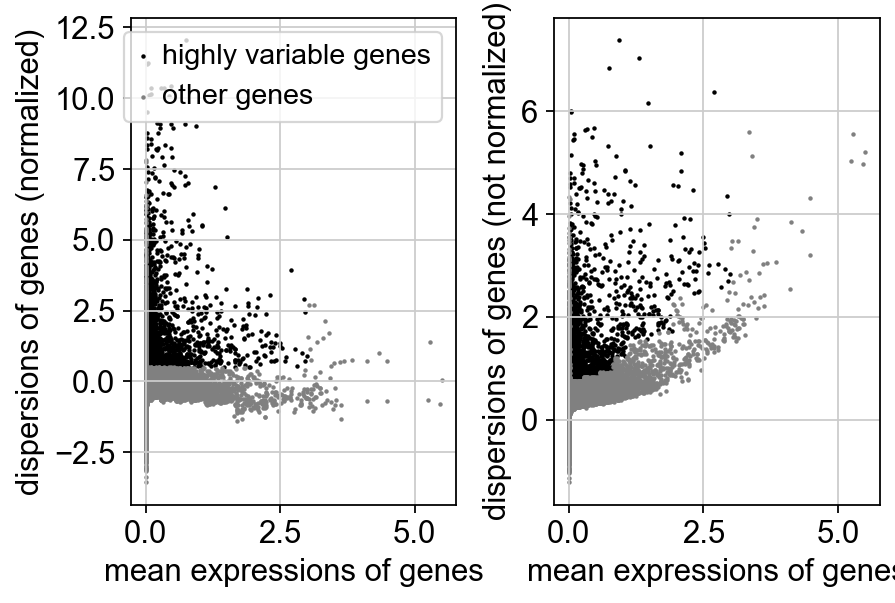

In [34]:
sc.pl.highly_variable_genes(adata)

In [35]:
#will need to update this after realignment
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['EGFP'] = False
adata.var.highly_variable['mScarlet'] = False
adata.var.highly_variable['Cre'] = False
adata.var.highly_variable['ERT'] = False
adata.var.highly_variable['iDTR'] = False
adata.var.highly_variable['tagBFP'] = False
adata.var.highly_variable['mKate2'] = False
adata.var.highly_variable['Akaluc'] = False
adata.var.highly_variable['tdTomato'] = False
adata.var.highly_variable['GLuc'] = False
adata.var.highly_variable['CLuc'] = False
adata.var.highly_variable['iRFP670'] = False

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_46494/3353793633.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['EGFP'] = False
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_46494/335379

In [36]:
adata.raw = adata

In [37]:
adata.write('write/GSE277777_allmice-IGO17721-DT.h5ad', compression='gzip')

In [38]:
sc.pp.scale(adata, max_value=10)

/Users/chanj2/opt/miniconda3/envs/part1-cellrank/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


## Principal component analysis

In [39]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=150)

computing PCA
    with n_comps=150
    finished (0:00:05)


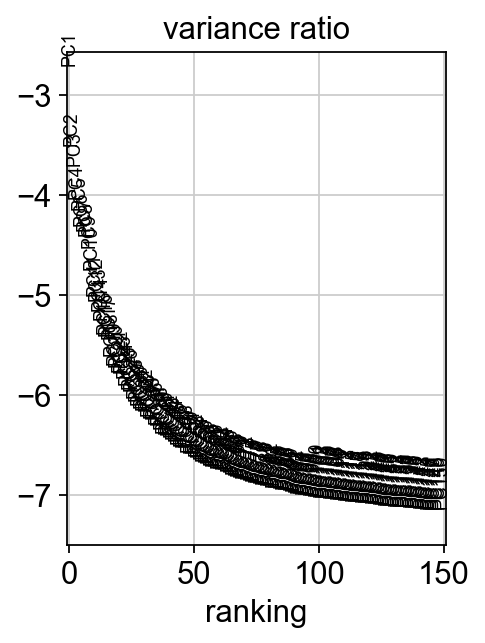

In [40]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=150)

Save the result.

In [41]:
adata.write(results_file, compression='gzip')

## Computing the neighborhood graph

In [42]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)


## Embedding the neighborhood graph

In [43]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:07)


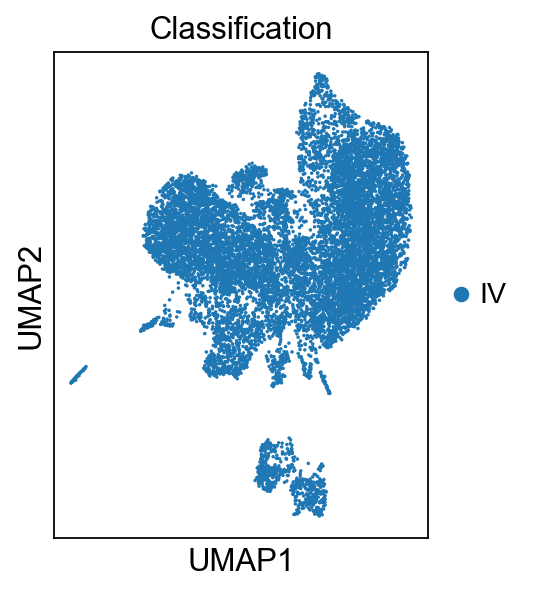

In [44]:
sc.pl.umap(adata, color=['Classification'])

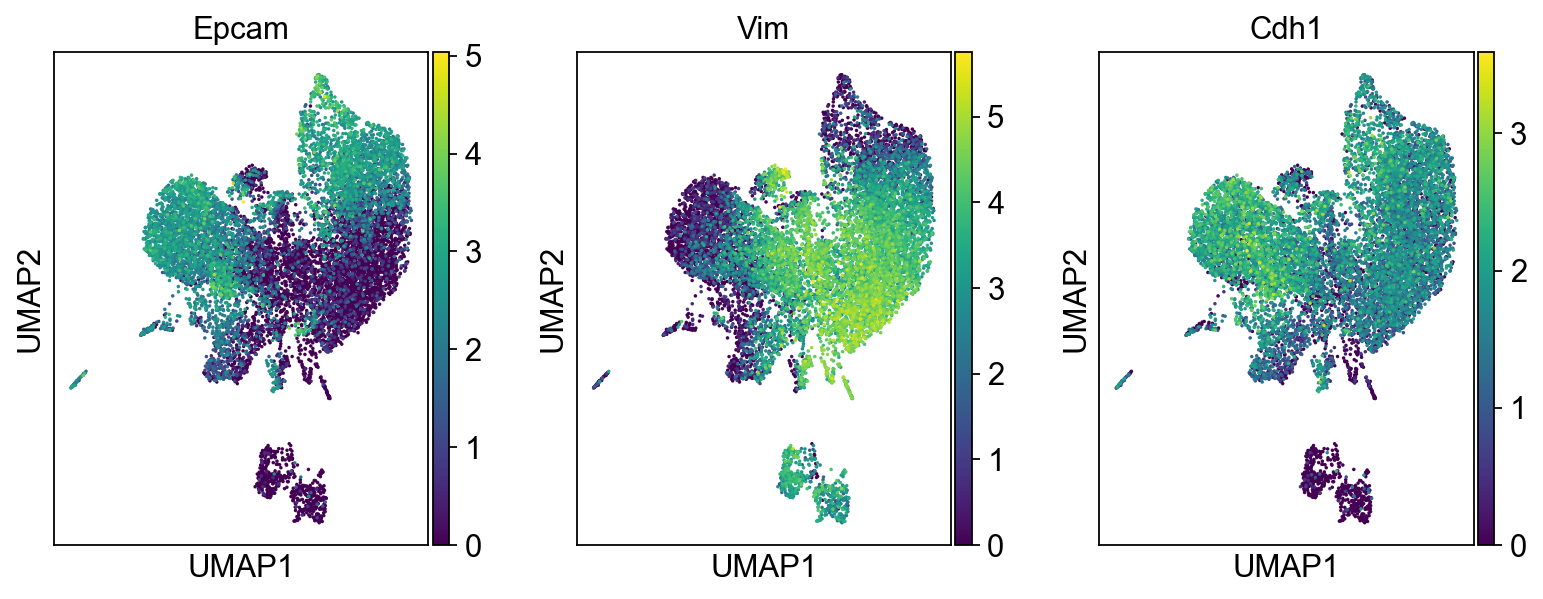

In [45]:
sc.pl.umap(adata, color=['Epcam','Vim', 'Cdh1',]) #'Ptprc','Cdh2'

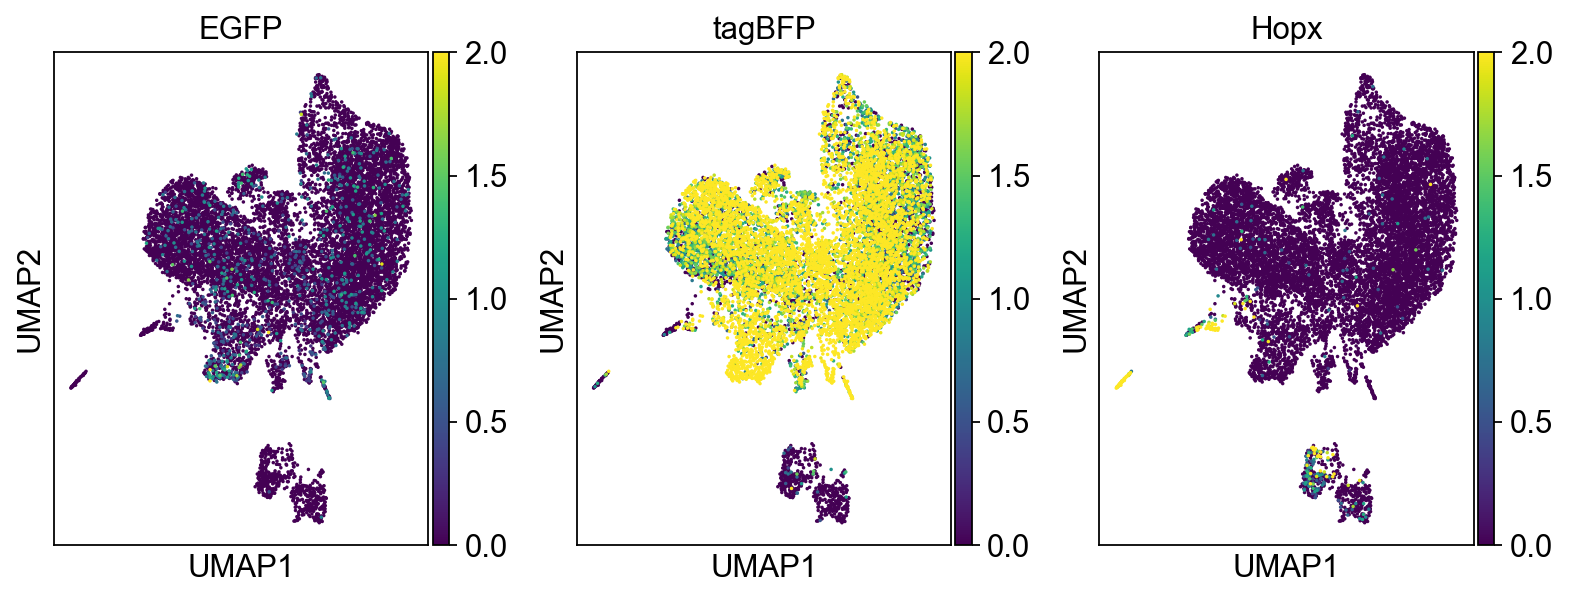

In [46]:
sc.pl.umap(adata, color=['EGFP','tagBFP','Hopx'], vmax=2)

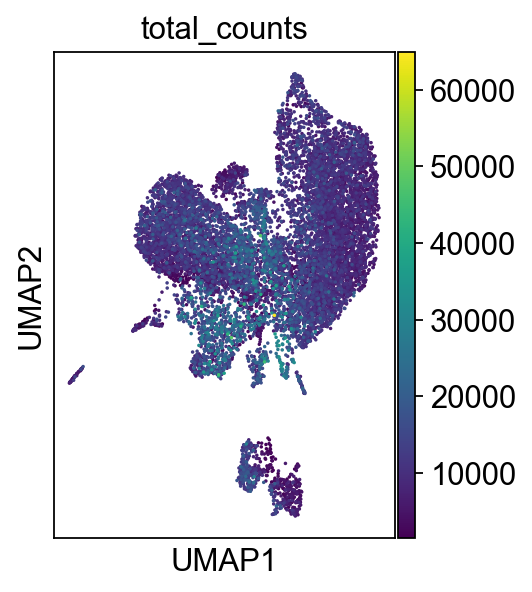

In [47]:
sc.pl.umap(adata, color=['total_counts'])

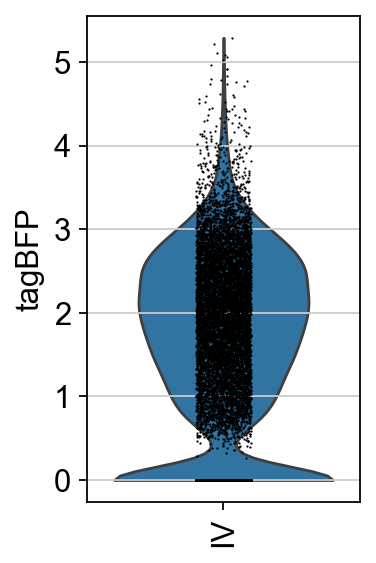

In [48]:
sc.pl.violin(adata, 'tagBFP','Classification',rotation=90)

## Clustering the neighborhood graph

In [49]:
sc.tl.leiden(adata, resolution=0.15)

running Leiden clustering


/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_46494/2358901094.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.15)


    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Plot the clusters, which agree quite well with the result of Seurat.

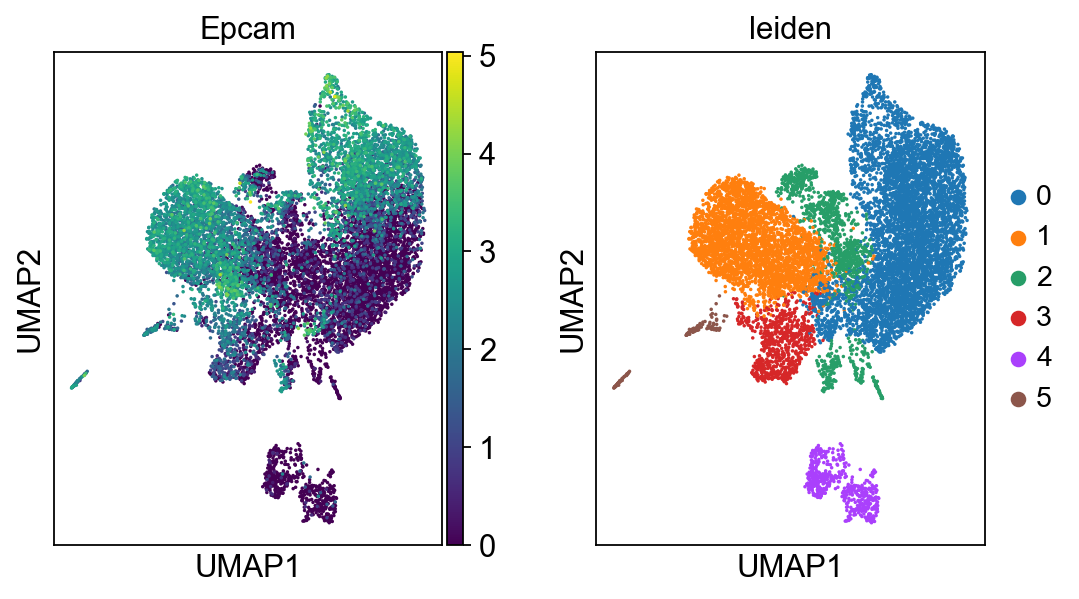

(None,)

In [50]:
sc.pl.umap(adata, color=['Epcam', # Tumor cells 'Sftpc'
                         'leiden']), #immune, 'Ptprc',
                         #  'Cd4', 'Cd8a', #T cell #'Cd3e',
                         # 'Cd19', 'Ms4a1', 'Cd22', # B cell
                         # #'Itgax', 'Il3ra', # Dendritic Cell
                         # 'Ncam1',# 'Ncr1', # NK Cell
                         # 'Cd34', # Hematopoetic stem cell
                         # #'Cd14', 'Cd33', # macrophage
                         # #'Ceacam8' # Granulocyte
                         # 'Itga2b', 'Itgb3', 'Selp', #platelet
                         # #'Gypa',  # erythrocyte
                         # #'Mcam', 'Vcam1', 'Pecam1', 'Sele', # endothelial cell
                         # 'Cd109', 'Wnt5a', 'Kras'])

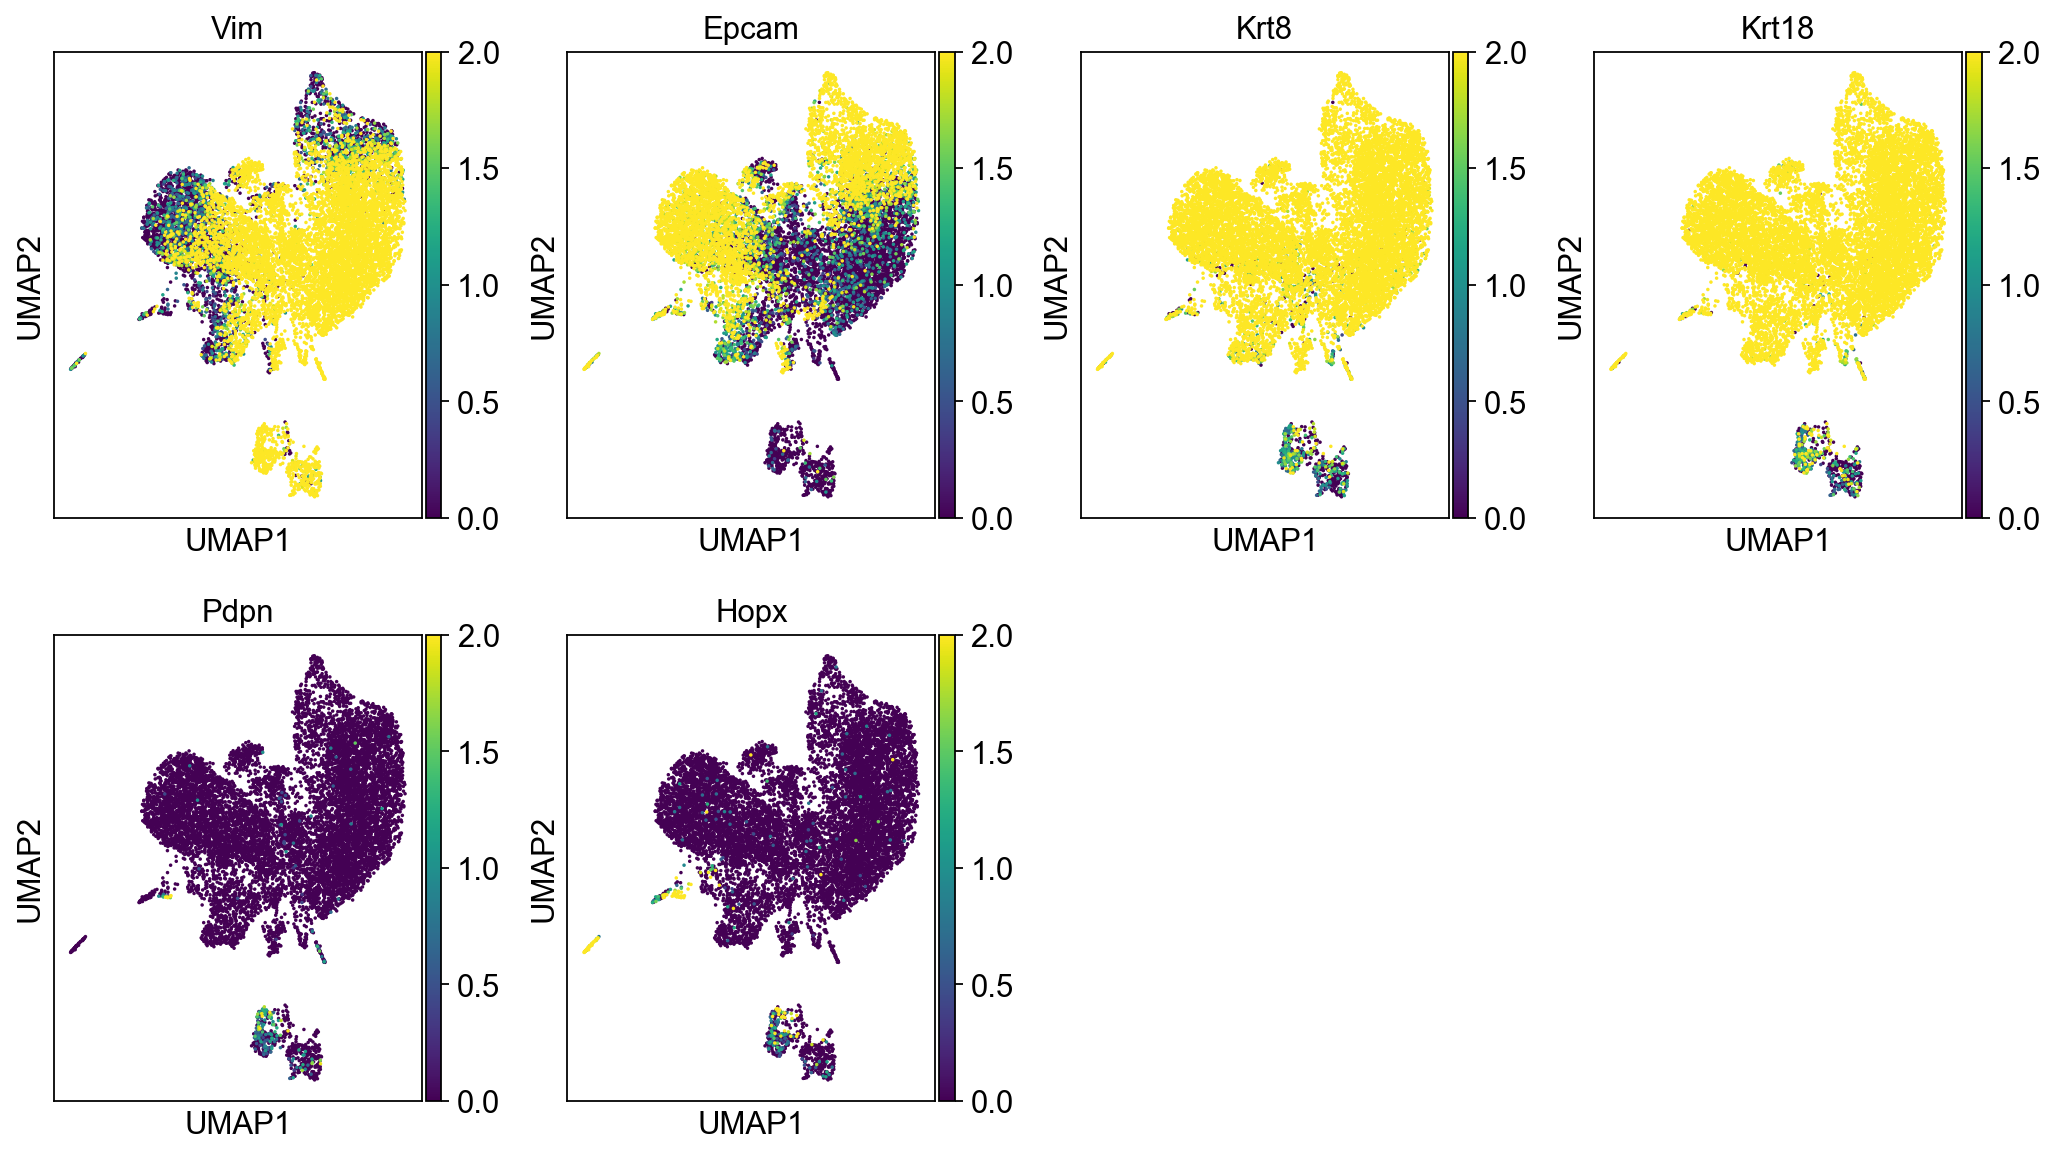

In [51]:
sc.pl.umap(adata, color=['Vim', 'Epcam', 'Krt8', 'Krt18', 'Pdpn', 'Hopx'], vmax=2) #'Pecam1',

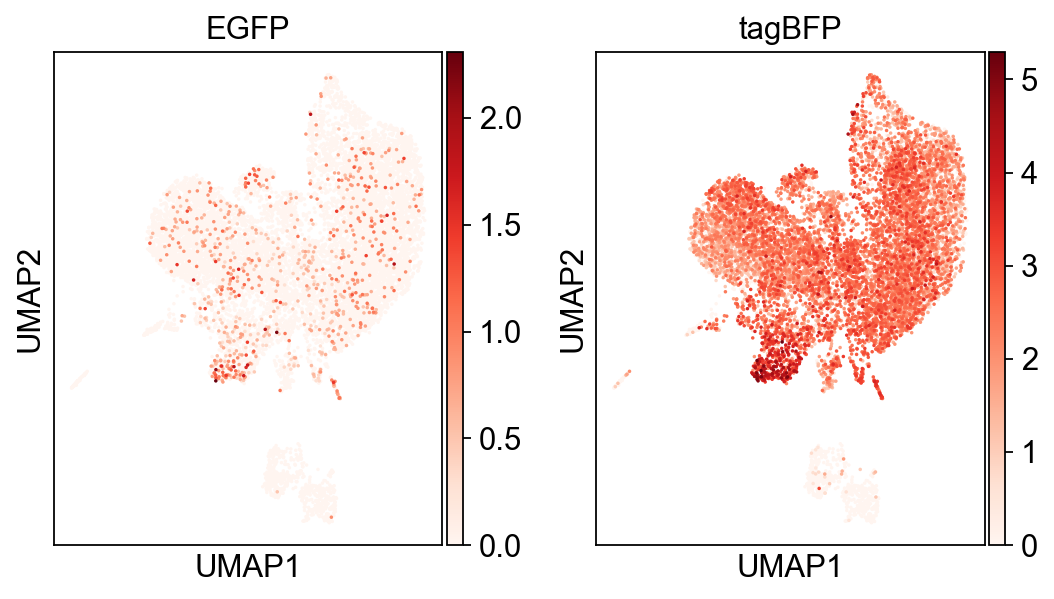

In [52]:
sc.pl.umap(adata, color=['EGFP','tagBFP',], cmap='Reds') #'mKate2''iDTR_count','mScarlet_count'

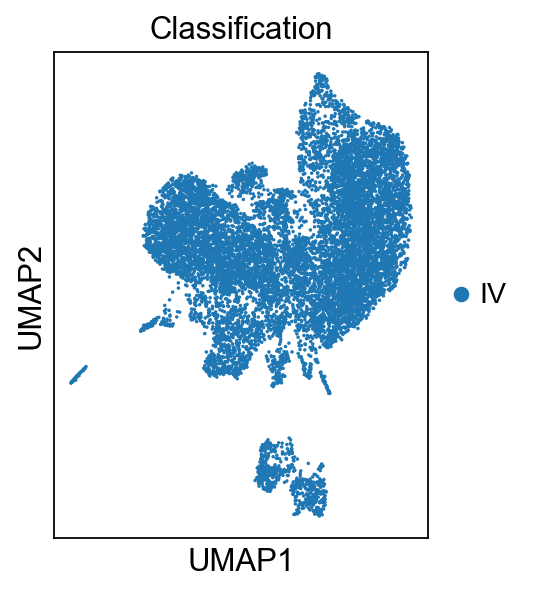

In [53]:
for label in adata.obs['Classification'].unique():
    sc.pl.umap(adata, color='Classification',groups=[label])

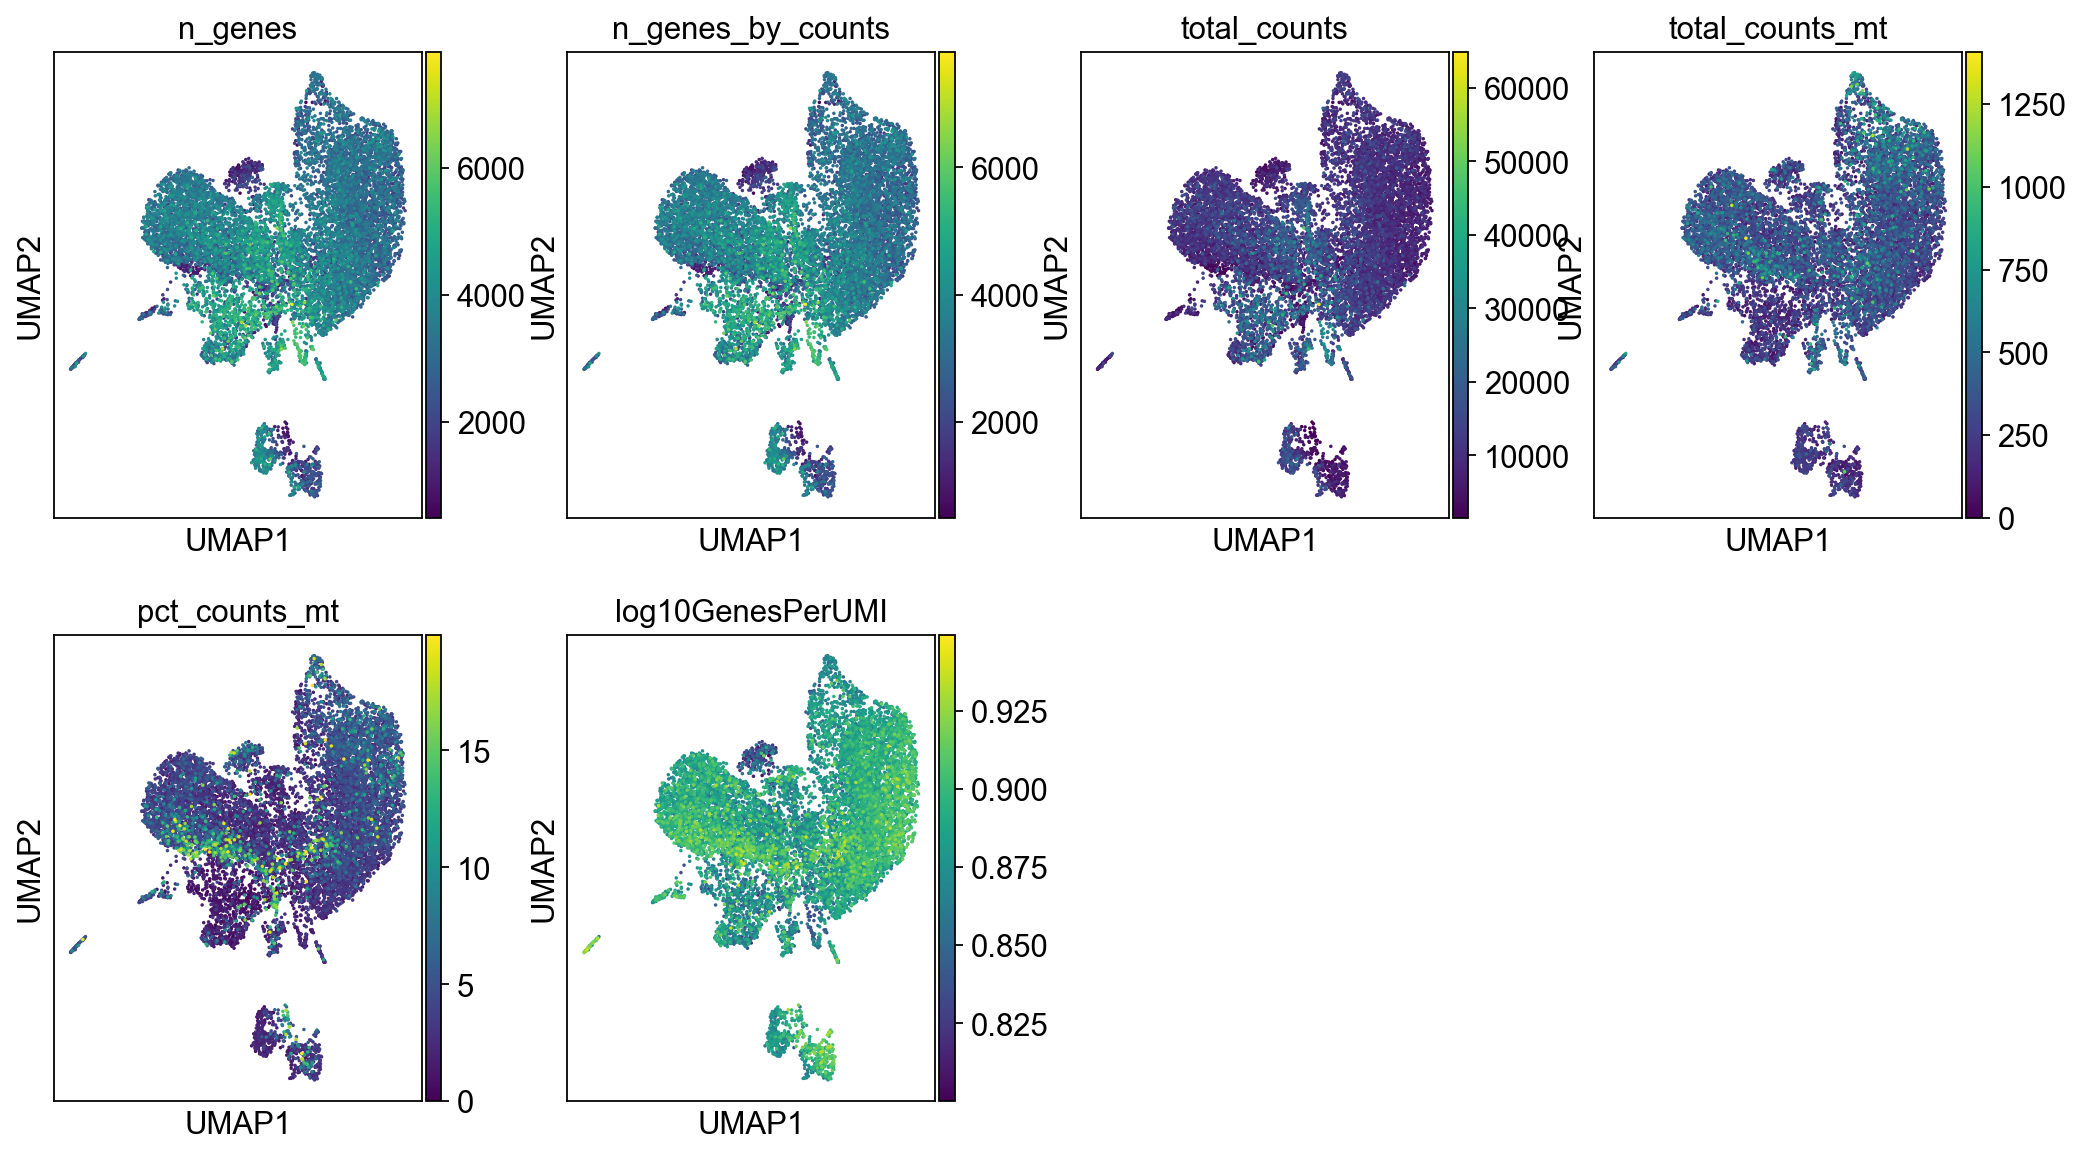

In [54]:
sc.pl.umap(adata,color=['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'log10GenesPerUMI'])

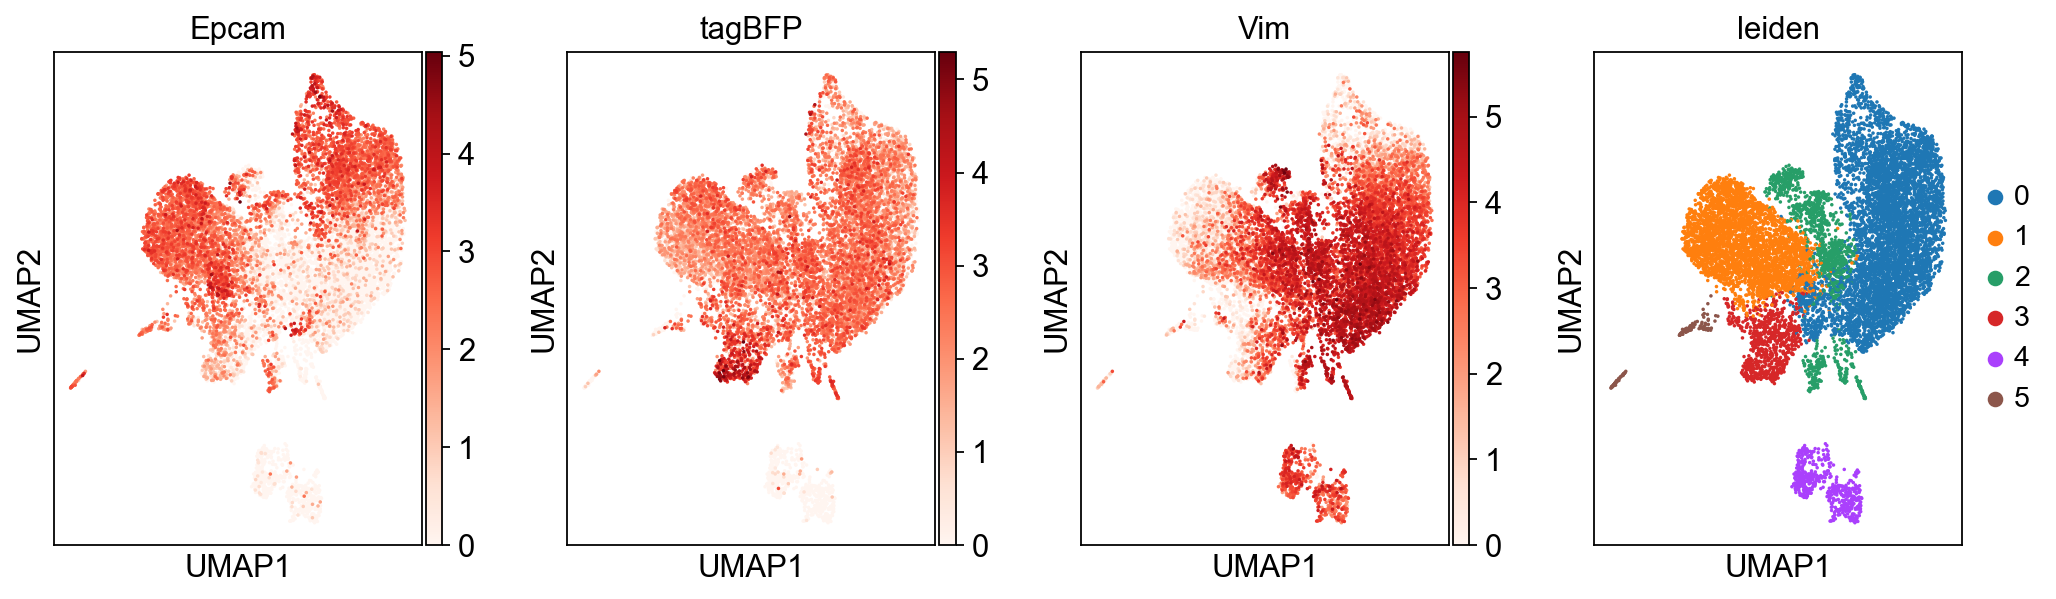

In [55]:
sc.pl.umap(adata, color=['Epcam','tagBFP','Vim','leiden',],cmap="Reds") #'Ptprc','iDTR_count',

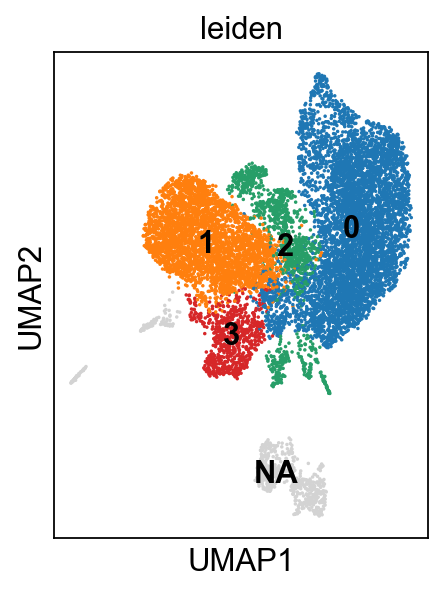

In [56]:
sc.pl.umap(adata, color=['leiden'], groups=['0','1','2','3'],legend_loc='on data')

## Select Tumor Cells

In [57]:
# Select only those subset of cells that are useful
adata2 = sc.read('write/GSE277777_allmice-IGO17721-DT.h5ad')
adata = adata2[adata.obs['leiden'].isin(['0','1','2','3']),:] # keep tumor cells
del adata2

In [58]:
#fix a bug; 'base' is None but that doesn't seem to have transferred
adata.uns['log1p'] = {}
adata.uns['log1p']['base'] = None

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_46494/2000007.py:2: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['log1p'] = {}


In [59]:
sc.pp.highly_variable_genes(adata)#, batch_key='Classification')

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [60]:
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['EGFP'] = False
adata.var.highly_variable['mScarlet'] = False
adata.var.highly_variable['Cre'] = False
adata.var.highly_variable['ERT'] = False
adata.var.highly_variable['iDTR'] = False
adata.var.highly_variable['tagBFP'] = False
adata.var.highly_variable['mKate2'] = False
adata.var.highly_variable['Akaluc'] = False
adata.var.highly_variable['tdTomato'] = False
adata.var.highly_variable['GLuc'] = False
adata.var.highly_variable['CLuc'] = False
adata.var.highly_variable['iRFP670'] = False

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_46494/320926811.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['EGFP'] = False
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_46494/3209268

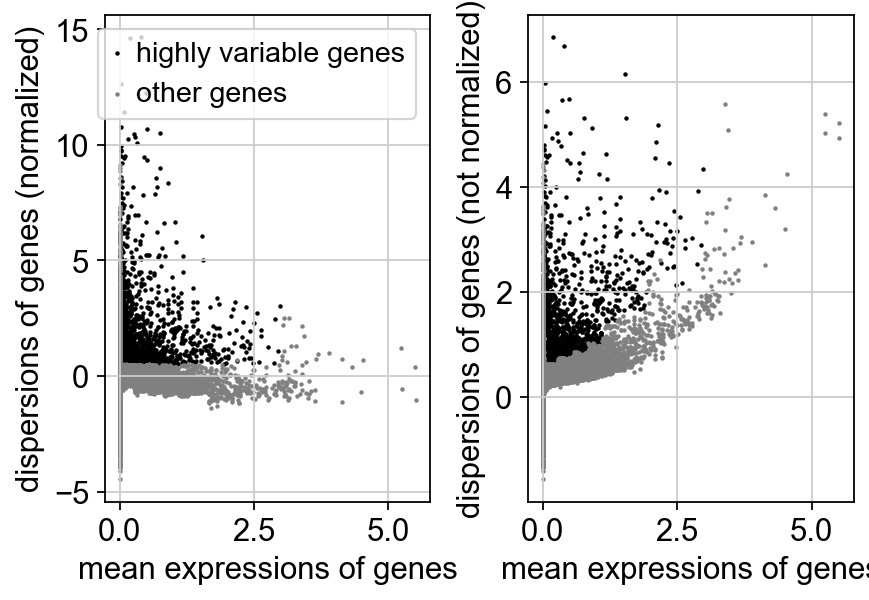

In [61]:
sc.pl.highly_variable_genes(adata)

In [62]:
adata.raw = adata

In [63]:
adata.write('write/GSE277777_allmice-tumor-IGO17721-DT.h5ad', compression='gzip')